In [2]:
import numpy as np
import pandas as pd
import pcg_skel
from common_setup import project_info, project_paths
from generate_column_cards import baseline_data_filename, preprocess_neuron, extract_baseline_data, card_figure_v2, output_count_bar
from src import card_plotting_code
from caveclient import CAVEclient
from meshparty import meshwork
import tqdm
from scipy import stats
import os

import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import dotenv
import card_config

visConfig = card_config.VisualizationConfig()
catConfig = card_config.CategoryConfig()
compartments_all = catConfig.compartments + ['inhib']
compartments_plus = catConfig.compartments[0:4] + ['inhib']
catConfig.compartments_plus = compartments_plus

env_name = 'slanted_update'
params = dotenv.dotenv_values(f'{env_name}.env')
version = 795

In [30]:
from generate_column_cards import process_presyn_df, meshwork, full_synapse_data, synapse_budget
from attach_details_to_baseline import baseline_counts, card_config
from statsmodels.stats.multitest import multipletests
import choosy

def load_table_df(root_id, project_paths, version):
    table_df = pd.read_feather(
        f"{project_paths.data}/specificity_data/slanted/v{version}/bin_count_{root_id}.feather"
    )

    table_df["cell_type"] = table_df["cell_type_comp"].apply(lambda x: x.split("_")[0])
    ct_lookup = {
        "L5-ET": "L5ET",
        "L5-IT": "L5IT",
        "L6-ITa": "L6ITa",
        "L6-CT": "L6CT",
        "L6-ITb": "L6ITb",
        "L6-ITc": "L6ITc",
        "L5-NP": "L5NP",
        "PTC": "Inh",
        "DTC": "Inh",
        "STC": "Inh",
        "ITC": "Inh",
    }
    table_df["cell_type"] = table_df["cell_type"].apply(lambda x: ct_lookup.get(x, x))
    table_df["comp"] = table_df["cell_type_comp"].apply(lambda x: x.split("_")[1])

    iidx = table_df.query("cell_type in @i_types").index
    table_df.loc[iidx, "comp"] = "inh"
    
    table_df["frac_baseline"] = stats.zscore(
        np.log2(
            table_df["bin_total"]
            * table_df["num_syn_overall"]
            / table_df["bin_total_overall"]
            + 0.5
        )
    )
    table_df["log_syn"] = stats.zscore(np.log2(table_df["num_syn"] + 1))

    return table_df

samp_comp = choosy.StructuredSampler(
    data=target_df,
    bin_column=['layer_bin'],
    count_column='comp',
)

samp_cell_type = choosy.StructuredSampler(
    data=target_df,
    bin_column=['comp', 'layer_bin'],
    count_column='cell_type',
)

def _specificity_general(
    pre_syn_df,
    sampler,
    n_repeat,
    category_types,
    test_threshold=10,
):
    bin_col = sampler._bin_column
    count_col = sampler._count_column

    # Observed number of synapses per counts
    obs_vals = (
        pre_syn_df.groupby(count_col).agg(num_syn=pd.NamedAgg(count_col, "count")).T
    )
    
    # Sample numbers of synapses per counts
    n_sample = pre_syn_df.groupby(bin_col).agg(
        num_syn=pd.NamedAgg(bin_col[0], "count")
    )["num_syn"]

    df_rand = sampler.sample_repeat(
        n_repeat=n_repeat,
        n_sample=n_sample,
    )
    
    # Compute min and max ratios with respect to the random distribution.
    prctile_rand = np.percentile(
        df_rand,
        [2.5, 97.5],
        axis=0,
    )
    prctile_rand[prctile_rand==0] = 1/(10*n_repeat)     #Avoid division by zero.

    mean_val = df_rand.mean()
    
    obs_vals = obs_vals.values.squeeze()
    odds_ratio = (obs_vals / mean_val).values.squeeze()
    or_lb = (obs_vals / prctile_rand[1]).squeeze()
    or_ub = (np.where(obs_vals>0, obs_vals, 0.5) / prctile_rand[0]).squeeze()
    
    # Put everything computed so far into a dataframe
    df = pd.DataFrame(
        {
            'obs_val': obs_vals,
            'lb_raw': prctile_rand[0],
            'ub_raw': prctile_rand[1],
            'odds_ratio': odds_ratio,
            'or_lb': or_lb,
            'or_ub': or_ub,
        },
        index=category_types,
    )
    
    # Measure a two-sided p-value based on the shuffle percentile.
    low_perc = (df_rand <= np.tile(obs_vals, (df_rand.shape[0], 1))).sum(axis=0) / n_repeat
    pval = np.where(low_perc<0.5, low_perc, 1-low_perc)
    df['pval'] = pval * 2
    
    # Correct signifiance for multiple comparisons
    sig = np.full(df['pval'].shape, False)
    df['sig'] = sig
    df_to_test = df.query('not (obs_val<=@test_threshold and ub_raw<=@test_threshold)')
    if len(df_to_test)>0:
        sig_nonnull, _, _, _ = multipletests(df_to_test['pval'], method="hs")
        df.loc[df_to_test.index, 'sig'] = sig_nonnull
    return df

def cell_type_specificity(
    pre_syn_df,
    n_repeat,
    catConfig,
    test_threshold=10,
):
    res_df_ct = _specificity_general(
        pre_syn_df,
        samp_cell_type,
        n_repeat,
        catConfig.order,
        test_threshold=test_threshold,
    )

    res_df_ct = card_plotting_code._augment_table_results(res_df_ct)
    res_df_ct.loc[res_df_ct.query('sig == False').index, 'direction'] = 'base'
    
    ignore_ind = res_df_ct[
        np.logical_and(
            res_df_ct['l2or_lb_cap'] == -res_df_ct['l2or_ub_cap'],
            res_df_ct['obs_val']==0
        )
    ].index
    res_df_ct.loc[ignore_ind, 'l2or_cap'] = np.nan
    res_df_ct.loc[ignore_ind, 'l2or_lb_cap'] = np.nan
    res_df_ct.loc[ignore_ind, 'l2or_ub_cap'] = np.nan

    return res_df_ct

def compartment_specificity(
    pre_syn_df,
    n_repeat,
    catConfig,
    test_threshold=10,
):
    res_df_comp = _specificity_general(
        pre_syn_df,
        samp_comp,
        n_repeat,
        catConfig.compartments_plus,
        test_threshold=test_threshold,
    )
    
    res_df_comp = card_plotting_code._augment_table_results(res_df_comp)
    res_df_comp.loc[res_df_comp.query('sig == False').index, 'direction'] = 'base'
    
    ignore_ind = res_df_comp[
        np.logical_and(
            res_df_comp['l2or_lb_cap'] == -res_df_comp['l2or_ub_cap'],
            res_df_comp['obs_val']==0
        )
    ].index
    res_df_comp.loc[ignore_ind, 'l2or_cap'] = np.nan
    res_df_comp.loc[ignore_ind, 'l2or_lb_cap'] = np.nan
    res_df_comp.loc[ignore_ind, 'l2or_ub_cap'] = np.nan

    return res_df_comp



In [31]:
base_path = f"{project_paths.base}/pipelines"
height_bounds = np.load(f"{project_paths.data}/height_bounds_v1.npy")
width_bounds = np.load(f"{project_paths.data}/width_bounds_v1.npy")
lb= np.load(f"{project_paths.data}/layer_bounds_v3.npy")
lb = lb- height_bounds[0]
height_bounds = height_bounds - height_bounds[0]

data_dir = f'../../notebooks/paper_versions/v{version}/data'
import dill as pickle
with open(f"{data_dir}/ctype_hues.pkl", "rb") as f:
    ctype_hues = pickle.load(f)

In [18]:
syn_profile_count = {}
syn_profile_count_long = {}

e_types = list(catConfig.e_types)
i_types = list(catConfig.i_types)
target_df.loc[target_df.query('cell_type in @i_types').index, 'comp'] = 'inhib'

for comp in compartments_plus:
    syn_profile_count[comp], syn_profile_count_long[comp] = baseline_counts(
        target_df.query("comp == @comp"), "layer_bin", "cell_type", order=catConfig.order
    )
    
_, syn_df_comp_count_long = baseline_counts(
    target_df, "layer_bin", "comp", order=compartments_plus
)

In [19]:
catConfig.compartments_plus = compartments_plus

target_df.drop(
    target_df.query('comp=="other"').index,
    inplace=True,
)

target_df['comp'] = target_df['comp'].astype(
    pd.CategoricalDtype(
        catConfig.compartments_plus,
        ordered=True,
    )
)

target_df["cell_type"] = target_df["cell_type"].astype(
    pd.CategoricalDtype(
        catConfig.order,
        ordered=True,
    )
)

In [27]:
i_oids = np.load(f'../../notebooks/paper_versions/v{version}/data/i_oids_v{version}.npy')

plot_dir = f'../../notebooks/paper_versions/v{version}/plots'

p_dir = 'specificity_plots'
d_dir = f'{p_dir}/data'

dfct_e = pd.read_feather(f'../../notebooks/paper_versions/v{version}/data/dfct_e.feather')

## Example cell

In [29]:
oid = 864691135572082925
bin_col = samp_cell_type._bin_column
count_col = samp_cell_type._count_column

nrn = meshwork.load_meshwork(f"{project_paths.skeletons}/skeleton_files/{oid}.h5")
pre_syn_df = process_presyn_df(nrn, target_df, catConfig)

pre_syn_df.drop(
    pre_syn_df.query('comp=="other"').index,
    inplace=True,
)
pre_syn_df['comp'] =pre_syn_df['comp'].astype(
    pd.CategoricalDtype(
        catConfig.compartments_plus,
        ordered=True,
    )
)
pre_syn_df['comp'] = pre_syn_df['comp'].fillna("inhib")

n_sample = pre_syn_df.groupby(bin_col).agg(
    num_syn=pd.NamedAgg(bin_col[0], "count")
)["num_syn"]

df_rand = samp_cell_type.sample_repeat(
    n_repeat=10_000,
    n_sample=n_sample,
)

num_syn_actual = pre_syn_df.groupby('cell_type').count()['id']

comp   layer_bin
soma   2            0
       3            0
       4            0
       5            0
       6            0
                   ..
inhib  25           7
       26           1
       27           0
       28           1
       29           1
Name: num_syn, Length: 140, dtype: int64

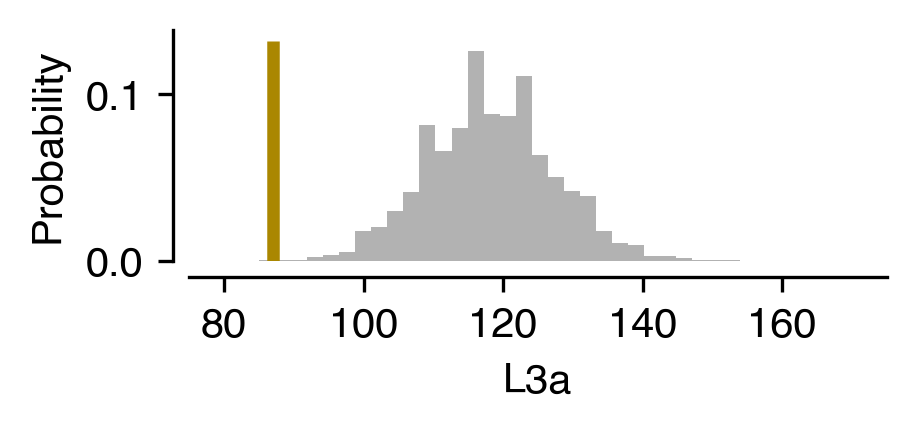

In [34]:
fig, ax = plt.subplots(figsize=(3,1), dpi=300)
ct = "L3a"

sns.histplot(
    df_rand[ct],
    bins=30,
    stat='probability',
    ax=ax,
    # color=ctype_hues[ct],
    color=(0.6, 0.6, 0.6),
    linewidth=0,
)

ax.vlines(num_syn_actual.loc[ct], 0, ax.get_ylim()[1], color=ctype_hues[ct], linewidth=3)

axis_resolution = 25
xmin = np.floor(min(num_syn_actual.loc[ct], df_rand[ct].min())/axis_resolution)*axis_resolution
xmax = np.ceil(max(df_rand[ct].max(), num_syn_actual.loc[ct])/axis_resolution)*axis_resolution
ax.set_xlim(xmin, xmax)
sns.despine(ax=ax, offset=4)

fig.savefig(f"{plot_dir}/shuffle_comparison_{ct}_{oid}.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(3,1), dpi=300)
ct = "L4a"

sns.histplot(
    df_rand[ct],
    bins=30,
    stat='probability',
    ax=ax,
    # color=ctype_hues[ct],
    color=(0.6, 0.6, 0.6),
    linewidth=0,
)

ax.vlines(num_syn_actual.loc[ct], 0, ax.get_ylim()[1], color=ctype_hues[ct], linewidth=3)

axis_resolution = 25
xmin = np.floor(min(num_syn_actual.loc[ct], df_rand[ct].min())/axis_resolution)*axis_resolution
xmax = np.ceil(max(df_rand[ct].max(), num_syn_actual.loc[ct])/axis_resolution)*axis_resolution
ax.set_xlim(xmin, xmax)
sns.despine(ax=ax, offset=4)

fig.savefig(f"{plot_dir}/shuffle_comparison_{ct}_{oid}.pdf", bbox_inches='tight')

In [35]:
xmin = np.floor(min(num_syn_actual.loc[ct], df_rand[ct].min())/100)*100
xmax = np.ceil(max(df_rand[ct].max(), num_syn_actual.loc[ct])/100)*100

# Precompute all preference data

In [ ]:
n_repeats = 10_000

for oid in tqdm.tqdm(i_oids):
    nrn = meshwork.load_meshwork(f"{project_paths.skeletons}/skeleton_files/{oid}.h5")
    pre_syn_df = process_presyn_df(nrn, target_df, catConfig)
    
    pre_syn_df.drop(
        pre_syn_df.query('comp=="other"').index,
        inplace=True,
    )
    pre_syn_df['comp'] =pre_syn_df['comp'].astype(
        pd.CategoricalDtype(
            catConfig.compartments_plus,
            ordered=True,
        )
    )
    pre_syn_df['comp'] = pre_syn_df['comp'].fillna("inhib")

    # Cell type specificity
    res_df_ct = cell_type_specificity(
        pre_syn_df,
        n_repeats,
        catConfig,
    )
    res_df_ct.reset_index().to_feather(f"{d_dir}/{oid}_ct_res.h5")
    pre_syn_df.to_feather(f"{d_dir}/{oid}_per_syn_df.h5")    

    # Compartment specificity
    res_df_comp = compartment_specificity(
        pre_syn_df,
        n_repeats,
        catConfig,
    )
    res_df_comp.reset_index().to_feather(f"{d_dir}/{oid}_comp_res.h5")

In [53]:
def load_files(root_id, data_dir):
    pre_syn_df = pd.read_feather(f"{data_dir}/{root_id}_per_syn_df.h5")    
    res_df_ct = pd.read_feather(f"{data_dir}/{root_id}_ct_res.h5")
    res_df_comp = pd.read_feather(f"{data_dir}/{root_id}_comp_res.h5")
    return (
        pre_syn_df,
        res_df_ct,
        res_df_comp,
    )

In [54]:
all_res_df_ct = []
all_comp_df = []
for root_id in tqdm.tqdm(i_oids):
    try:
        pre_syn_df, res_df_ct, res_df_comp = load_files(root_id, d_dir)
        res_df_ct['root_id'] = root_id
        res_df_comp['root_id'] = root_id
        all_res_df_ct.append(res_df_ct)
        all_comp_df.append(res_df_comp)
    except:
        continue
        
all_res_ct_df = pd.concat(all_res_df_ct, ignore_index=True)
all_comp_df = pd.concat(all_comp_df, ignore_index=True)

all_res_ct_df.loc[all_res_ct_df.query("sig==False").index, "l2or"] = 0
all_res_ct_df.loc[all_res_ct_df.query("l2or!=l2or").index, "l2or"] = np.NaN

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 214.28it/s]


In [46]:
base_data_dir = f'../../notebooks/paper_versions/v{version}/data'

im_df = pd.read_feather(f'{base_data_dir}/inhibitory_motif_table.feather')
syn_table_select = im_df.drop(columns=e_types+i_types).merge(
    all_res_ct_df.rename(columns={'index': 'cell_type'}).pivot_table(
        index="root_id",
        columns="cell_type",
        values="l2or",
    ).reset_index(),
    left_on='pt_root_id',
    right_on='root_id',
    how='left'
).drop(columns='root_id')

ct_list_exc = ['L2a',
       'L2b', 'L2c', 'L3a', 'L3b', 'L4a', 'L4b', 'L4c','L5a',
       'L5b', 'L5ET', 'L5NP', 'L6short-a', 'L6short-b', 'L6tall-a', 'L6tall-b', 'L6tall-c',
       'L6wm',]

div_cmap = sns.diverging_palette(
    181,
    35,
    s=80,
    l=70,
    as_cmap=True,
)

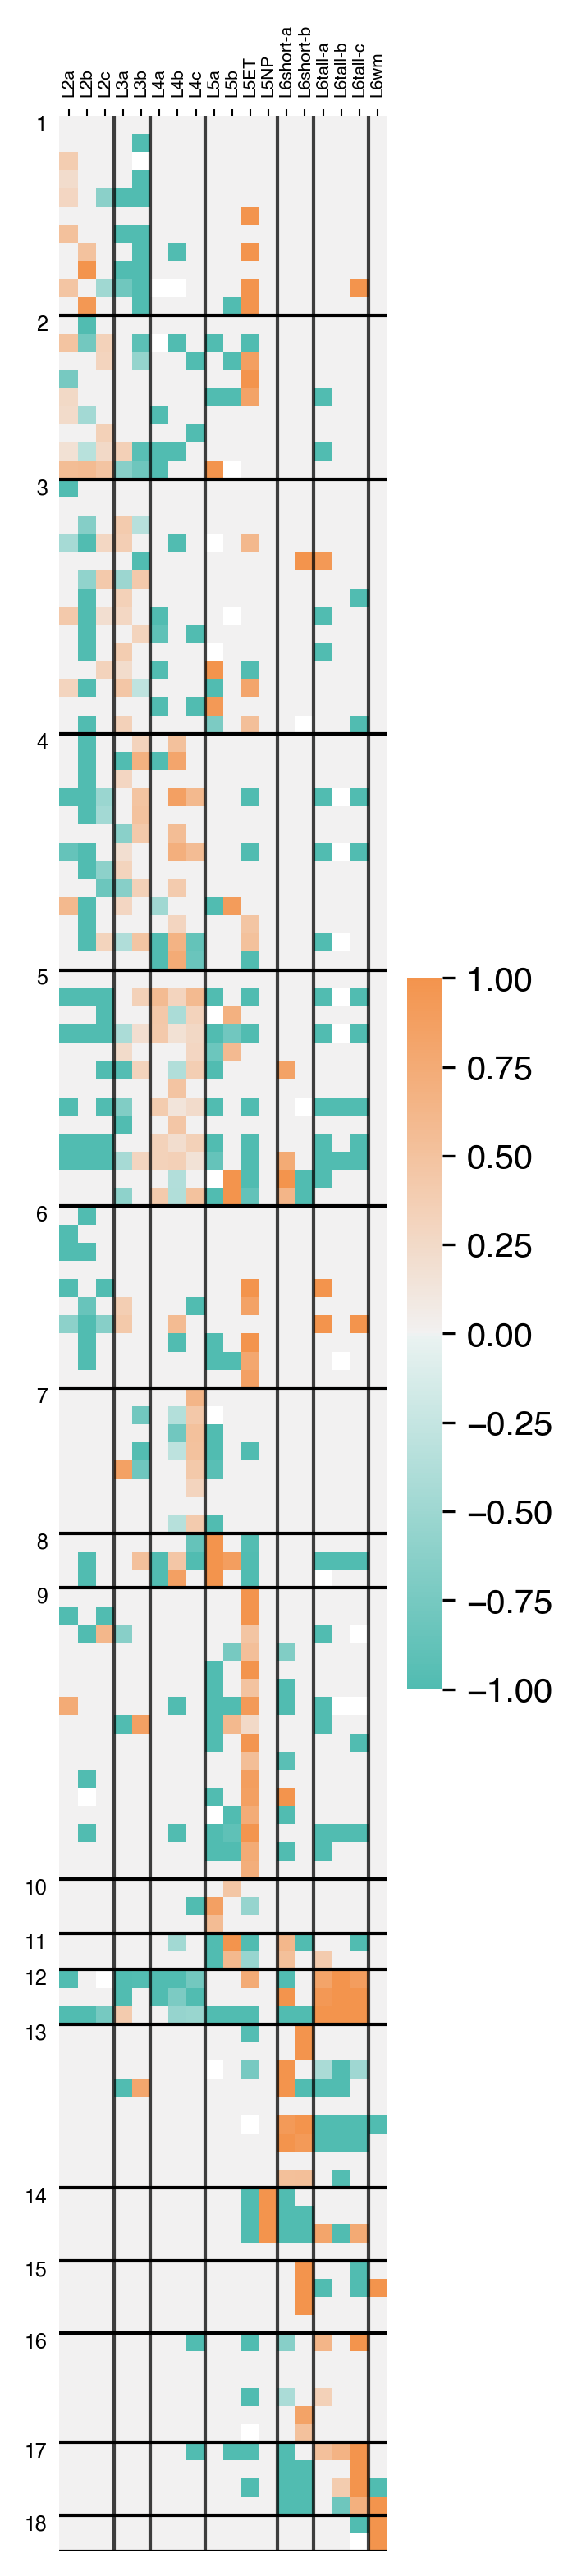

In [47]:
yvals = np.cumsum(
    syn_table_select.query('consensus_label < 18').groupby("consensus_label").count()["cell_type_pre"]
).values

fig, axes = plt.subplots(
    figsize=(3,15),
    ncols=2,
    sharey=True,
    dpi=300,
    gridspec_kw={"width_ratios": [5, 2], "wspace": 0},
)
ct_list = e_types + i_types
ax = axes[0]
sns.heatmap(
    syn_table_select.query("consensus_label < 18")
    .sort_values(by=["consensus_label", "soma_depth_pre"])[ct_list_exc],
    square=True,
    cmap = div_cmap,
    vmin=-np.log2(2),
    vmax=np.log2(2),
    ax=ax,
    cbar=True,
    cbar_kws={"shrink": 0.25},
)
ax.hlines(yvals, 0, len(ct_list_exc), color="k", linewidth=1)
ax.vlines(
    [3, 5, 8, 12, 14, len(e_types)-1],
    0,
    len(syn_table_select),
    color="k",
    linewidth=1,
    alpha=0.75,
)

_ = ax.set_yticks([])

ax.set_yticks(np.concatenate(([0], yvals[0:-1])) + 0.5)
ax.set_yticklabels(
    np.arange(
        len(syn_table_select.query("consensus_label < 18")["consensus_label"].unique())
    )+1,
    fontdict={"fontsize": 6},
)
ax.xaxis.set_ticks_position("top")
ax.tick_params(length=2, width=0.5, axis="x")
ax.tick_params(length=0, width=0, axis="y")
ax.set_xticks(np.arange(len(ct_list_exc)) + 0.5)
ax.set_xticklabels(ct_list_exc, rotation=90, fontdict={"size": 5})
ax.set_xlabel("")

ax = axes[1]
ax.set_visible(False)

# fig.savefig(f'{plot_dir}/selectivity_all_cell.pdf')

In [48]:
agg_selectivity_df = (
    syn_table_select.replace([np.inf, -np.inf], np.nan)
    .groupby("consensus_label")[e_types]
    .agg(np.nanmedian)
    .fillna(0)
)


agg_selectivity_df_long = agg_selectivity_df.reset_index().melt(
    id_vars = 'consensus_label',
    value_vars = e_types,
    value_name = 'selectivity',
)

ct_list_rep = {ct: ii for ii, ct in enumerate(e_types)}

agg_selectivity_df_long['post_idx'] = agg_selectivity_df_long['variable'].replace(ct_list_rep)

agg_selectivity_df_long['abs_sel'] = np.abs(agg_selectivity_df_long['selectivity'])

In [49]:
agg_selectivity_df_long['abs_sel'] = np.abs(np.sign(
    agg_selectivity_df_long['selectivity']
))

In [50]:
agg_selectivity_df_long['sel_sign'] = np.sign(
    agg_selectivity_df_long['selectivity']
)

Text(0, 0.5, 'Inhibitory Motif Group')

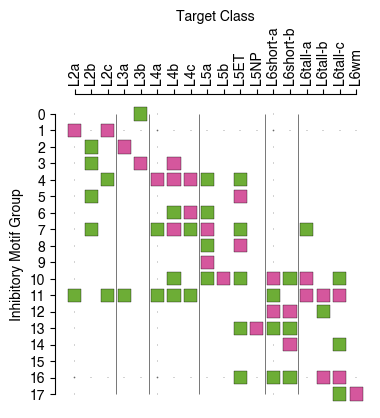

In [51]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

sns.scatterplot(
    x="post_idx",
    y="consensus_label",
    size="abs_sel",
    size_norm=(0.01, 1),
    sizes=(0.01, 90),
    hue="sel_sign",
    # palette=sns.diverging_palette(240, 10, as_cmap=True),
    palette="PiYG_r",
    hue_norm=(-1.5,1.5),
    data=agg_selectivity_df_long.query('consensus_label < 18'),
    edgecolor="k",
    marker='s',
    linewidth=0.25,
    ax=ax,
    legend=False,
)

ax.invert_yaxis()
ax.set_yticks(np.arange(agg_selectivity_df_long["consensus_label"].max() - 1))
ax.vlines(
    np.array([3, 5, 8, 12, 14])-0.5,
    0,
    agg_selectivity_df_long["consensus_label"].max()-2,
    color="k",
    linewidth=0.5,
    alpha=0.75,
)
ax.set_xticks(np.arange(len(e_types)))

sns.despine(ax=ax, offset=4, trim=True, top=False, bottom=True)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

_ = ax.set_xticklabels(e_types, rotation=90)

ax.set_xlabel('Target Class')
ax.set_ylabel('Inhibitory Motif Group')

# fig.savefig(f"{plot_dir}/inhibitory_motif_output_selectivity_agg_median.pdf", bbox_inches="tight")